<a href="https://colab.research.google.com/github/evbevz/epoxy-supervisor/blob/main/EpoxyLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import google.colab
    IS_COLAB_ENV = True
except:
    IS_COLAB_ENV = False
if IS_COLAB_ENV:
    %pip install ultralytics
    !git clone https://github.com/evbevz/epoxy-supervisor.git
    dirBase = '/content/drive/MyDrive/Colab Notebooks/'

    from google.colab import drive
    drive.mount('/content/drive/')
else:
    dirBase = '/home/nikolay/opencv/'
%cd "{dirBase}epoxy-supervisor/"

In [2]:
import epoxylib
import os
from ultralytics import YOLO

# Значение уверенности в правильности распознавания, ниже которого не будем считать, что точки определились правильно. Т.е. координаты такой точки будем считать ложными и точку игнорировать.
kptConfidence = 0.8 # Сейчас точки если и распознаются, то с уверенностью больше 0.9

# Калибровочный файл в котором хранятся уровни от 0 до 20мл. В виде координат X,Y центра эллипса поверхности эпоксидки на каждом уровне.
filenameAnnotation = dirBase + 'epoxy-supervisor/samples/EpoxyLevelCalibrate.annotations.xml'

# Файл весов обученной для распознавания модели
#filenameAIModel = dirBase + 'epoxy-supervisor/weights/epoxy-supervisor.20241228.best.pt'
#filenameAIModel = dirBase + 'epoxy-supervisor/weights/es.yolo11s-pose.20250121.epoch400.pt'
filenameAIModel = dirBase + 'epoxy-supervisor/weights/es.yolo11s-pose.20250213.best.pt'

# Изображение для предсказания уровня эпоксидки
#filenameInjectorCam = 'epoxy-supervisor/samples/fail01.png'
#filenameInjectorCam = 'epoxy-supervisor/samples/000030.png'
#filenameInjectorCam20 = dirBase + 'epoxy-supervisor/samples/20ml.png'
#filenameInjectorCam18 = dirBase + 'epoxy-supervisor/samples/18ml.png'
#filenameInjectorCam10 = dirBase + 'epoxy-supervisor/samples/10ml.png'
#filenameInjectorCam0 = dirBase + 'epoxy-supervisor/samples/fail01.png'
#filenameInjectorCam = dirBase + 'epoxy-supervisor/frames-009/00900040.png'
#filenameInjectorCam1 = dirBase + 'epoxy-supervisor/lvl-test/frames/lvl-01803.png' #3.83
#filenameInjectorCam2 = dirBase + 'epoxy-supervisor/lvl-test/frames/lvl-02211.png' #2.31
#filenameInjectorCam3 = dirBase + 'epoxy-supervisor/lvl-test/frames/lvl-02212.png' #None

# Калибруем шприц
arrayEpoxyLevel = epoxylib.Calibrate(filenameAnnotation)

# Загружаем модель
model = YOLO(filenameAIModel)

# Запрос уровня по изображению
#level = 20
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam, kptConfidence, level)
#print (f"Уровень эпоксидки: {level}")
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam1, kptConfidence, 3.83)
#print (f"Уровень эпоксидки: {level}")
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam2, kptConfidence, 2.31)
#print (f"Уровень эпоксидки: {level}")
#level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, filenameInjectorCam3, kptConfidence, None)
#print (f"Уровень эпоксидки: {level}")

Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
--- Keypoints instance: ---
 ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9996, 0.9990, 0.9998, 0.9999]], device='cuda:0')
data: tensor([[[8.5625e+02, 9.3129e+02, 9.9959e-01],
         [1.1004e+03, 1.0185e+03, 9.9895e-01],
         [9.9678e+02, 9.2182e+02, 9.9981e-01],
         [9.5764e+02, 1.0334e+03, 9.9985e-01]]], device='cuda:0')
has_visible: True
orig_shape: (1200, 1600)
shape: torch.Size([1, 4, 3])
xy: tensor([[[ 856.2546,  931.2891],
         [1100.4365, 1018.4734],
         [ 996.7838,  921.8242],
         [ 957.6370, 1033.4285]]], device='cuda:0')
xyn: tensor([[[0.5352, 0.7761],
         [0.6878, 0.8487],
         [0.6230, 0.7682],
         [0.5985, 0.8612]]], device='cuda:0')
--- Keypoints instance: ---
 ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9295, 0.0075, 0.0485, 0.9828]], device='cuda:0')
data: tensor([[[7.9287e+01, 3.6354e+01, 

In [19]:
# Постороения списка уровней по изображениям в папке
dataPath = dirBase + 'epoxy-supervisor/lvl-test/frames'
data = os.listdir(dataPath)
data.sort()
levels = []
index_with_none = []
level = 20
for i, file in enumerate(data):
    fullPath = f"{dataPath}/{file}"
    level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, fullPath , kptConfidence, level)
    levels.append(level)
    if level is not None:
        print (f"Файл: {file}. Уровень эпоксидки: {level:.2f}")
    else:
        index_with_none.append(i)
        print (f"Файл: {file}. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!")

Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00001.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00002.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00003.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00004.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00005.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00006.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00007.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/epoxy-supervisor/runs/pose/predict3
Файл: lvl-00008.png. Уровень эпоксидки: 20.00
Results saved to /home/nikolay/opencv/ep

KeyboardInterrupt: 

In [4]:
for i in index_with_none:
    print (f"Индекс: {i},\tФайл: {data[i]}. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!")
    levels[i] = 0

Индекс: 1802,	Файл: lvl-01803.png. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Индекс: 2210,	Файл: lvl-02211.png. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!
Индекс: 2211,	Файл: lvl-02212.png. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!


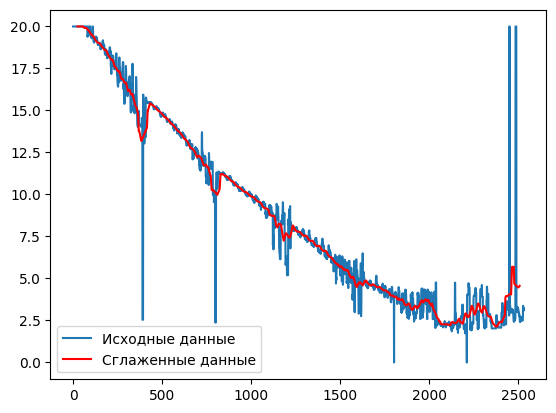

In [5]:
# https://www.delftstack.com/howto/python/smooth-data-in-python/
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd

# Применение фильтра Савицкого-Голея для сглаживания
#levels_savgol = savgol_filter(levels, 11, 3)
levels_savgol = savgol_filter(levels, 50, 3)

# Метод скользящего среднего
# Простой и проверенный метод сглаживания — скользящее среднее. Он балансирует между скоростью вычислений и точностью границ данных.
# Использование функции np.cumsum для подсчёта скользящего среднего обеспечивает быстроту, но может приводить к краевым эффектам.
# Метод np.convolve с параметром mode='same' предотвращает изменение размера массива и позволяет сравнить сглаженные данные с исходными.
levels_cumsum = np.cumsum(levels)
levels_convolve = np.convolve(levels,1,mode='same')

#
levels_pd = pd.Series(levels).rolling(window=50, center=True).mean()

#from operator import sub
#delta = map(sub,levels,levels_pd)
delta = np.array(levels) - np.array(levels_pd)

plt.plot(levels, label='Исходные данные')
plt.plot(levels_pd, color='red', label='Сглаженные данные')
#plt.plot(delta, color='green', label='Разница от среднего')
plt.legend()
plt.show()

In [11]:
#@title Make video
!ffmpeg -threads auto -hwaccel cuda -y -framerate 5 -i {dirBase}epoxy-supervisor/runs/pose/predict/lvl-%5d.jpg -c:v h264_nvenc {dirBase}epoxy-supervisor/lvl-test.output.es20250213.mp4

ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab